## 1. Setup and Imports

In [1]:
import os
import re
import random
import json
from pathlib import Path
from datasets import Dataset, DatasetDict, concatenate_datasets, Features, Value, Sequence
import pandas as pd

import torch
from transformers import (
    AutoTokenizer,
    AutoModelForSequenceClassification,
    Trainer,
    TrainingArguments,
    DataCollatorWithPadding,
)
from peft import LoraConfig, get_peft_model

import numpy as np
from sklearn.metrics import (
    precision_recall_fscore_support, 
    accuracy_score, 
    f1_score
)
import matplotlib.pyplot as plt
import seaborn as sns
import optuna

# Set random seeds for reproducibility
random.seed(42)
np.random.seed(42)
torch.manual_seed(42)

## 2. Data Paths and Loading

In [2]:
# Define data paths
TRAIN_DIR = Path(r"/kaggle/input/nlp-augmentedset/aug_train")
DEV_DIR   = Path(r"/kaggle/input/nlp-augmentedset/aug_dev")
TEST_DIR  = Path(r"/kaggle/input/nlp-augmentedset/test")

# Verify paths exist
assert TRAIN_DIR.exists(), f"Train directory not found: {TRAIN_DIR}"
assert DEV_DIR.exists(),   f"Dev directory not found: {DEV_DIR}"
assert TEST_DIR.exists(),  f"Test directory not found: {TEST_DIR}"

def load_docie_docs(folder: Path, recursive: bool = False):
    """Load DocIE documents from JSON files"""
    docs = []
    pattern = "**/*.json" if recursive else "*.json"
    for file in folder.glob(pattern):
        data = json.loads(file.read_text(encoding="utf-8"))
        if isinstance(data, list):
            docs.extend(data)
        else:
            docs.append(data)
    return docs

# Load datasets
train_docs = load_docie_docs(TRAIN_DIR)
dev_docs   = load_docie_docs(DEV_DIR)
test_docs  = load_docie_docs(TEST_DIR, recursive=True)

print(f"Loaded - Train: {len(train_docs)} | Dev: {len(dev_docs)} | Test: {len(test_docs)}")

Loaded - Train: 204 | Dev: 88 | Test: 248


## 3. Exploratory Data Analysis

Top 10 Relation Types:
  HasPart: 328
  HasEffect: 268
  DiplomaticRelation: 180
  LocatedIn: 176
  InterestedIn: 152
  OwnerOf: 128
  NominatedFor: 100
  SaidToBeTheSameAs: 100
  PartOf: 72
  Creator: 68

Total relation types: 68
Total relation instances: 2444


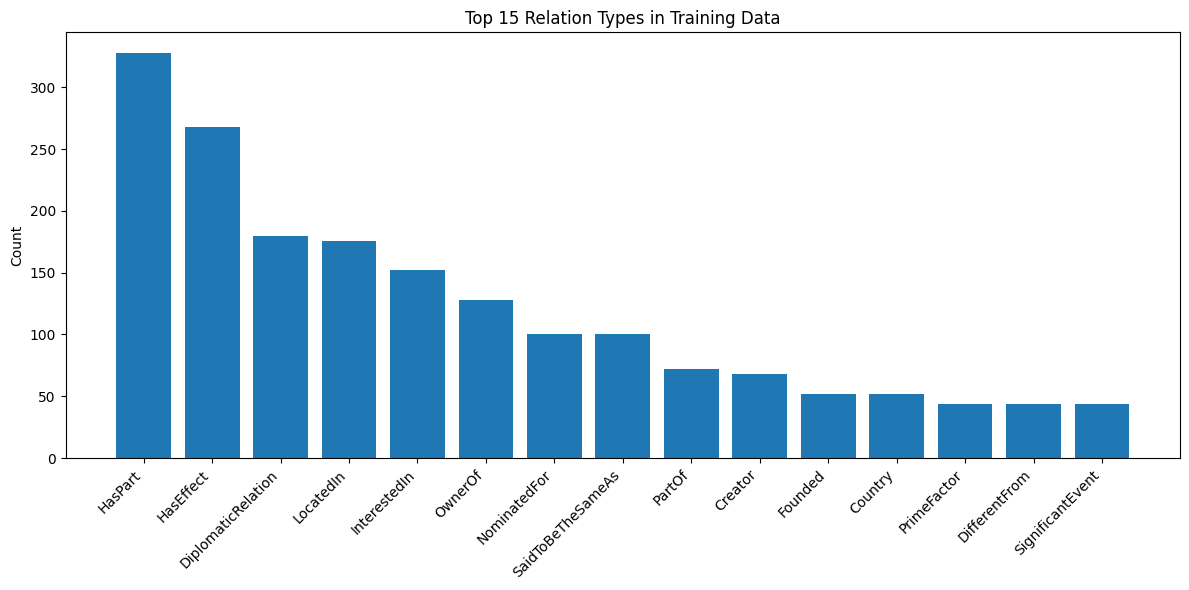

In [3]:
# Analyze relation types in training data
from collections import Counter

relation_counts = Counter(triple["relation"] for doc in train_docs for triple in doc["triples"])
print("Top 10 Relation Types:")
for relation, count in relation_counts.most_common(10):
    print(f"  {relation}: {count}")

print(f"\nTotal relation types: {len(relation_counts)}")
print(f"Total relation instances: {sum(relation_counts.values())}")

# Visualize relation distribution
plt.figure(figsize=(12, 6))
top_relations = relation_counts.most_common(15)
relations, counts = zip(*top_relations)
plt.bar(range(len(relations)), counts)
plt.xticks(range(len(relations)), relations, rotation=45, ha='right')
plt.title('Top 15 Relation Types in Training Data')
plt.ylabel('Count')
plt.tight_layout()
plt.show()

## 4. Relation Extraction Data Preparatio

In [4]:
def create_re_examples(docs, split_name):
    """
    Create relation extraction examples from DocIE documents.
    For each document, create positive examples from triples and negative examples
    by randomly sampling entity pairs that don't have relations.
    """
    examples = []
    
    for doc in docs:
        # Skip documents without triples or entities
        if not doc.get("triples") or not doc.get("entities"):
            continue
            
        # Get document text
        text = doc.get("doc") or doc.get("document")
        if not text:
            continue
            
        # Extract all entity mentions (first mention of each entity)
        entity_mentions = [ent["mentions"][0] for ent in doc["entities"] if ent.get("mentions")]
        
        # Create set of positive relation pairs
        positive_pairs = {(triple["head"], triple["tail"]) for triple in doc["triples"]}
        
        # Create positive examples
        for triple in doc["triples"]:
            examples.append({
                "split": split_name,
                "sentence": text,
                "head": triple["head"],
                "tail": triple["tail"],
                "label": triple["relation"],
            })
            
        # Create negative examples (same number as positive)
        negative_count = 0
        max_attempts = len(doc["triples"]) * 10  # Avoid infinite loops
        attempts = 0
        
        while negative_count < len(doc["triples"]) and attempts < max_attempts:
            attempts += 1
            if len(entity_mentions) < 2:
                break
                
            head, tail = random.sample(entity_mentions, 2)
            if (head, tail) not in positive_pairs and (tail, head) not in positive_pairs:
                examples.append({
                    "split": split_name,
                    "sentence": text,
                    "head": head,
                    "tail": tail,
                    "label": "no_relation",
                })
                negative_count += 1
    
    return examples

# Create relation extraction examples
print("Creating RE examples...")
train_examples = create_re_examples(train_docs, "train")
dev_examples = create_re_examples(dev_docs, "dev")
test_examples = create_re_examples(test_docs, "test")

print(f"RE Examples - Train: {len(train_examples)} | Dev: {len(dev_examples)} | Test: {len(test_examples)}")

# Analyze label distribution
all_examples = train_examples + dev_examples
label_counts = Counter(ex["label"] for ex in all_examples)
print(f"\nLabel distribution:")
for label, count in label_counts.most_common():
    print(f"  {label}: {count}")

Creating RE examples...
RE Examples - Train: 4888 | Dev: 2398 | Test: 0

Label distribution:
  no_relation: 3643
  HasPart: 538
  HasEffect: 425
  LocatedIn: 187
  SaidToBeTheSameAs: 184
  DiplomaticRelation: 180
  InterestedIn: 152
  NominatedFor: 148
  OwnerOf: 136
  InfluencedBy: 96
  ApprovedBy: 96
  Uses: 94
  UsedBy: 80
  Creator: 77
  PartOf: 76
  BasedOn: 75
  Affiliation: 72
  ContributedToCreativeWork: 72
  Causes: 60
  Founded: 56
  Country: 56
  DifferentFrom: 52
  PrimeFactor: 44
  SignificantEvent: 44
  HasWorksInTheCollection: 40
  FollowedBy: 40
  Follows: 40
  PublishedIn: 39
  Studies: 36
  InspiredBy: 36
  SharesBorderWith: 32
  AdjacentStation: 28
  PositionHeld: 24
  OfficialLanguage: 20
  IssuedBy: 20
  PracticedBy: 16
  WorkLocation: 16
  Partner: 16
  LanguageUsed: 12
  CountryOfCitizenship: 12
  EducatedAt: 12
  Author: 12
  AcademicDegree: 12
  FieldOfWork: 12
  FoundedBy: 12
  MemberOf: 8
  Continent: 8
  Location: 8
  LanguageOfWorkOrName: 8
  NativeLanguage

## 5. Data Preprocessing and Tokenization

In [5]:
# Create label mappings
all_labels = sorted(set(ex["label"] for ex in train_examples + dev_examples))
label2id = {label: idx for idx, label in enumerate(all_labels)}
id2label = {idx: label for label, idx in label2id.items()}

print(f"Number of relation classes: {len(all_labels)}")
print("Label mappings created")

# Initialize tokenizer
model_name = "bert-base-uncased"
tokenizer = AutoTokenizer.from_pretrained(model_name, use_fast=True)
max_length = 128

def tokenize_re_examples(examples):
    """
    Tokenize relation extraction examples.
    Format: [HEAD] [SEP] [TAIL] [SEP] [SENTENCE]
    """
    sentences = []
    labels = []
    
    for example in examples:
        # Create input text with special format
        input_text = f"{example['head']} [SEP] {example['tail']} [SEP] {example['sentence']}"
        sentences.append(input_text)
        labels.append(label2id[example["label"]])
    
    # Tokenize
    tokenized = tokenizer(
        sentences,
        truncation=True,
        padding=True,
        max_length=max_length,
        return_tensors="pt"
    )
    
    return {
        "input_ids": tokenized["input_ids"],
        "attention_mask": tokenized["attention_mask"],
        "labels": torch.tensor(labels)
    }

# Create datasets
train_dataset = Dataset.from_list(train_examples)
dev_dataset = Dataset.from_list(dev_examples)

# Apply tokenization
def tokenize_function(examples):
    return tokenizer(
        [f"{head} [SEP] {tail} [SEP] {sentence}" for head, tail, sentence in 
         zip(examples["head"], examples["tail"], examples["sentence"])],
        truncation=True,
        padding=True,
        max_length=max_length
    )

train_dataset = train_dataset.map(
    lambda examples: {
        **tokenize_function(examples),
        "labels": [label2id[label] for label in examples["label"]]
    },
    batched=True,
    remove_columns=["split", "sentence", "head", "tail", "label"]
)

dev_dataset = dev_dataset.map(
    lambda examples: {
        **tokenize_function(examples),
        "labels": [label2id[label] for label in examples["label"]]
    },
    batched=True,
    remove_columns=["split", "sentence", "head", "tail", "label"]
)

# Set format for PyTorch
train_dataset.set_format("torch", columns=["input_ids", "attention_mask", "labels"])
dev_dataset.set_format("torch", columns=["input_ids", "attention_mask", "labels"])

print("Tokenization completed")

Number of relation classes: 76
Label mappings created


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

Map:   0%|          | 0/4888 [00:00<?, ? examples/s]

Map:   0%|          | 0/2398 [00:00<?, ? examples/s]

Tokenization completed


## 6. Evaluation Metrics

In [6]:
def compute_metrics_re(eval_pred):
    """Compute F1 score and accuracy for relation extraction"""
    predictions, labels = eval_pred
    predictions = np.argmax(predictions, axis=1)
    
    # Filter out padding tokens
    mask = labels != -100
    predictions = predictions[mask]
    labels = labels[mask]
    
    precision, recall, f1, _ = precision_recall_fscore_support(
        labels, predictions, average="micro", zero_division=0
    )
    accuracy = accuracy_score(labels, predictions)
    
    return {
        "precision": precision,
        "recall": recall,
        "f1": f1,
        "accuracy": accuracy
    }

# Data collator
data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

## 7. BERT Baseline

In [7]:
def train_bert_baseline():
    """Train BERT baseline for relation extraction"""
    print("Training BERT Baseline...")
    
    # Load model
    model = AutoModelForSequenceClassification.from_pretrained(
        model_name,
        num_labels=len(label2id),
        id2label=id2label,
        label2id=label2id
    )
    
    # Training arguments
    training_args = TrainingArguments(
        output_dir="outputs/bert-re-baseline",
        eval_strategy="epoch",
        save_strategy="epoch",
        load_best_model_at_end=True,
        metric_for_best_model="eval_f1",
        num_train_epochs=3,
        per_device_train_batch_size=8,
        per_device_eval_batch_size=16,
        learning_rate=2e-5,
        weight_decay=0.01,
        logging_steps=50,
        save_total_limit=1,
        fp16=torch.cuda.is_available(),
        report_to="none"
    )
    
    # Initialize trainer
    trainer = Trainer(
        model=model,
        args=training_args,
        train_dataset=train_dataset,
        eval_dataset=dev_dataset,
        tokenizer=tokenizer,
        data_collator=data_collator,
        compute_metrics=compute_metrics_re
    )
    
    # Train
    trainer.train()
    
    # Evaluate
    results = trainer.evaluate()
    print(f"Baseline Results - F1: {results['eval_f1']:.4f}, Accuracy: {results['eval_accuracy']:.4f}")
    
    return trainer, results

# Train baseline
baseline_trainer, baseline_results = train_bert_baseline()

Training BERT Baseline...


model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/tmp/ipykernel_35/1364303269.py:32: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(
/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


Epoch,Training Loss,Validation Loss,Precision,Recall,F1,Accuracy
1,1.793100,2.485485,0.515430,0.515430,0.515430,0.515430
2,1.318100,2.642509,0.509591,0.509591,0.509591,0.509591
3,1.132000,2.593836,0.501251,0.501251,0.501251,0.501251


/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


Baseline Results - F1: 0.5154, Accuracy: 0.5154


## 8. Hyperparameter Tuning - Full Fine-Tuning

In [8]:
def bert_ft_objective(trial):
    """Objective function for hyperparameter tuning"""
    # Suggest hyperparameters
    lr = trial.suggest_float("learning_rate", 1e-5, 5e-5, log=True)
    batch_size = trial.suggest_categorical("batch_size", [8, 16, 32])
    
    # Create model
    model = AutoModelForSequenceClassification.from_pretrained(
        model_name,
        num_labels=len(label2id),
        id2label=id2label,
        label2id=label2id
    )
    
    # Training arguments
    args = TrainingArguments(
        output_dir=f"tmp/bert-re-ft-{trial.number}",
        per_device_train_batch_size=batch_size,
        per_device_eval_batch_size=batch_size * 2,
        eval_strategy="steps",
        eval_steps=20,
        logging_steps=10,
        save_strategy="no",
        max_steps=100,
        learning_rate=lr,
        fp16=torch.cuda.is_available(),
        report_to="none",
    )
    
    # Trainer
    trainer = Trainer(
        model=model,
        args=args,
        train_dataset=train_dataset,
        eval_dataset=dev_dataset,
        tokenizer=tokenizer,
        data_collator=data_collator,
        compute_metrics=compute_metrics_re,
    )
    
    trainer.train()
    results = trainer.evaluate()
    return results["eval_f1"]

# Run hyperparameter optimization
print("Starting hyperparameter tuning for Full Fine-Tuning...")
study_ft = optuna.create_study(direction="maximize")
study_ft.optimize(bert_ft_objective, n_trials=8)

print(f"Best FT params: {study_ft.best_params} → Dev-F1 = {study_ft.best_value:.4f}")
best_ft_params = study_ft.best_params

[I 2025-05-29 14:29:29,054] A new study created in memory with name: no-name-6579338b-e07d-45c8-acd7-e06676f8f980


Starting hyperparameter tuning for Full Fine-Tuning...


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/tmp/ipykernel_35/3497921421.py:31: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(
/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


Step,Training Loss,Validation Loss,Precision,Recall,F1,Accuracy
20,3.505200,3.343216,0.500000,0.500000,0.500000,0.500000
40,2.967100,2.886131,0.500000,0.500000,0.500000,0.500000
60,2.594100,2.757642,0.500000,0.500000,0.500000,0.500000
80,2.525200,2.693777,0.500000,0.500000,0.500000,0.500000
100,2.563900,2.673172,0.500000,0.500000,0.500000,0.500000


/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked t

[I 2025-05-29 14:31:23,339] Trial 0 finished with value: 0.5 and parameters: {'learning_rate': 1.9690687839546327e-05, 'batch_size': 16}. Best is trial 0 with value: 0.5.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/tmp/ipykernel_35/3497921421.py:31: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(
/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


Step,Training Loss,Validation Loss,Precision,Recall,F1,Accuracy
20,3.267900,3.077513,0.500000,0.500000,0.500000,0.500000
40,2.737400,2.733768,0.500000,0.500000,0.500000,0.500000
60,2.385600,2.645492,0.500000,0.500000,0.500000,0.500000
80,2.291800,2.569892,0.500000,0.500000,0.500000,0.500000
100,2.301700,2.551199,0.500000,0.500000,0.500000,0.500000


/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked t

[I 2025-05-29 14:33:18,259] Trial 1 finished with value: 0.5 and parameters: {'learning_rate': 3.0226455940776865e-05, 'batch_size': 16}. Best is trial 0 with value: 0.5.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/tmp/ipykernel_35/3497921421.py:31: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(
/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


Step,Training Loss,Validation Loss,Precision,Recall,F1,Accuracy
20,3.109800,2.943089,0.500000,0.500000,0.500000,0.500000
40,2.629500,2.669254,0.500000,0.500000,0.500000,0.500000
60,2.273400,2.590083,0.500000,0.500000,0.500000,0.500000
80,2.163400,2.537930,0.500000,0.500000,0.500000,0.500000
100,2.168000,2.533046,0.500000,0.500000,0.500000,0.500000


/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked t

[I 2025-05-29 14:35:13,139] Trial 2 finished with value: 0.5 and parameters: {'learning_rate': 3.9472294186685935e-05, 'batch_size': 16}. Best is trial 0 with value: 0.5.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/tmp/ipykernel_35/3497921421.py:31: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(
/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


Step,Training Loss,Validation Loss,Precision,Recall,F1,Accuracy
20,3.564500,3.353159,0.500000,0.500000,0.500000,0.500000
40,2.899700,2.905937,0.500000,0.500000,0.500000,0.500000
60,2.622800,2.774098,0.500000,0.500000,0.500000,0.500000
80,2.553400,2.725313,0.500000,0.500000,0.500000,0.500000
100,2.620100,2.705800,0.500000,0.500000,0.500000,0.500000


/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked t

[I 2025-05-29 14:37:00,534] Trial 3 finished with value: 0.5 and parameters: {'learning_rate': 2.2240151789182633e-05, 'batch_size': 8}. Best is trial 0 with value: 0.5.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/tmp/ipykernel_35/3497921421.py:31: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(
/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


Step,Training Loss,Validation Loss,Precision,Recall,F1,Accuracy
20,3.894300,3.790862,0.480400,0.480400,0.480400,0.480400
40,3.482000,3.400169,0.500000,0.500000,0.500000,0.500000
60,3.154400,3.181211,0.500000,0.500000,0.500000,0.500000
80,3.037700,3.074346,0.500000,0.500000,0.500000,0.500000
100,3.070200,3.039072,0.500000,0.500000,0.500000,0.500000


/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked t

[I 2025-05-29 14:38:47,933] Trial 4 finished with value: 0.5 and parameters: {'learning_rate': 1.0839717617792423e-05, 'batch_size': 8}. Best is trial 0 with value: 0.5.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/tmp/ipykernel_35/3497921421.py:31: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(
/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


Step,Training Loss,Validation Loss,Precision,Recall,F1,Accuracy
20,3.800600,3.647724,0.500000,0.500000,0.500000,0.500000
40,3.261300,3.239113,0.500000,0.500000,0.500000,0.500000
60,2.961700,3.020208,0.500000,0.500000,0.500000,0.500000
80,2.850100,2.919456,0.500000,0.500000,0.500000,0.500000
100,2.803700,2.894614,0.500000,0.500000,0.500000,0.500000


/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked t

[I 2025-05-29 14:41:19,963] Trial 5 finished with value: 0.5 and parameters: {'learning_rate': 1.0477353137562125e-05, 'batch_size': 32}. Best is trial 0 with value: 0.5.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/tmp/ipykernel_35/3497921421.py:31: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(
/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


Step,Training Loss,Validation Loss,Precision,Recall,F1,Accuracy
20,3.766400,3.612449,0.498749,0.498749,0.498749,0.498749
40,3.127600,3.117325,0.500000,0.500000,0.500000,0.500000
60,2.815200,2.907210,0.500000,0.500000,0.500000,0.500000
80,2.732800,2.849080,0.500000,0.500000,0.500000,0.500000
100,2.677700,2.835886,0.500000,0.500000,0.500000,0.500000


/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked t

[I 2025-05-29 14:43:52,178] Trial 6 finished with value: 0.5 and parameters: {'learning_rate': 1.3998481654801245e-05, 'batch_size': 32}. Best is trial 0 with value: 0.5.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/tmp/ipykernel_35/3497921421.py:31: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(
/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


Step,Training Loss,Validation Loss,Precision,Recall,F1,Accuracy
20,3.932600,3.947371,0.353211,0.353211,0.353211,0.353211
40,3.581600,3.580063,0.498749,0.498749,0.498749,0.498749
60,3.286300,3.377973,0.500000,0.500000,0.500000,0.500000
80,3.162000,3.250141,0.500000,0.500000,0.500000,0.500000
100,3.195000,3.240846,0.500000,0.500000,0.500000,0.500000


/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked t

[I 2025-05-29 14:45:39,918] Trial 7 finished with value: 0.5 and parameters: {'learning_rate': 1.0031034333577952e-05, 'batch_size': 8}. Best is trial 0 with value: 0.5.


Best FT params: {'learning_rate': 1.9690687839546327e-05, 'batch_size': 16} → Dev-F1 = 0.5000


## 9. Hyperparameter Tuning - LoRA

In [9]:
def bert_lora_objective(trial):
    """Objective function for LoRA hyperparameter tuning"""
    # Suggest hyperparameters
    lr = trial.suggest_float("learning_rate", 1e-5, 1e-3, log=True)
    r = trial.suggest_categorical("r", [4, 8, 16])
    alpha = trial.suggest_categorical("alpha", [16, 32])
    dropout = trial.suggest_float("dropout", 0.0, 0.3)
    batch_size = trial.suggest_categorical("batch_size", [8, 16, 32])
    
    # Configure LoRA
    lora_config = LoraConfig(
        task_type="SEQ_CLS",
        inference_mode=False,
        r=r,
        lora_alpha=alpha,
        lora_dropout=dropout,
    )
    
    # Create base model and apply LoRA
    base_model = AutoModelForSequenceClassification.from_pretrained(
        model_name,
        num_labels=len(label2id),
        id2label=id2label,
        label2id=label2id
    )
    model = get_peft_model(base_model, lora_config)
    
    # Training arguments
    args = TrainingArguments(
        output_dir=f"tmp/bert-re-lora-{trial.number}",
        per_device_train_batch_size=batch_size,
        per_device_eval_batch_size=batch_size * 2,
        eval_strategy="steps",
        eval_steps=20,
        logging_steps=10,
        save_strategy="no",
        max_steps=100,
        learning_rate=lr,
        fp16=torch.cuda.is_available(),
        report_to="none",
    )
    
    # Trainer
    trainer = Trainer(
        model=model,
        args=args,
        train_dataset=train_dataset,
        eval_dataset=dev_dataset,
        tokenizer=tokenizer,
        data_collator=data_collator,
        compute_metrics=compute_metrics_re,
    )
    
    trainer.train()
    results = trainer.evaluate()
    return results["eval_f1"]

# Run LoRA hyperparameter optimization
print("Starting hyperparameter tuning for LoRA...")
study_lora = optuna.create_study(direction="maximize")
study_lora.optimize(bert_lora_objective, n_trials=8)

print(f"Best LoRA params: {study_lora.best_params} → Dev-F1 = {study_lora.best_value:.4f}")
best_lora_params = study_lora.best_params

[I 2025-05-29 14:45:39,929] A new study created in memory with name: no-name-adb76a0d-9f92-4ff1-b029-5dbef84ed99f


Starting hyperparameter tuning for LoRA...


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/tmp/ipykernel_35/4028515001.py:44: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(
No label_names provided for model class `PeftModelForSequenceClassification`. Since `PeftModel` hides base models input arguments, if label_names is not given, label_names can't be set automatically within `Trainer`. Note that empty label_names list will be used instead.
/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


Step,Training Loss,Validation Loss,Precision,Recall,F1,Accuracy
20,2.497300,2.863982,0.500000,0.500000,0.500000,0.500000
40,2.386700,2.844931,0.500000,0.500000,0.500000,0.500000
60,2.359800,2.948403,0.500000,0.500000,0.500000,0.500000
80,2.310500,3.004616,0.500000,0.500000,0.500000,0.500000
100,2.274900,2.989102,0.500000,0.500000,0.500000,0.500000


/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked t

[I 2025-05-29 14:47:54,546] Trial 0 finished with value: 0.5 and parameters: {'learning_rate': 0.00046474260073101195, 'r': 16, 'alpha': 32, 'dropout': 0.26915667575813446, 'batch_size': 32}. Best is trial 0 with value: 0.5.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/tmp/ipykernel_35/4028515001.py:44: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(
No label_names provided for model class `PeftModelForSequenceClassification`. Since `PeftModel` hides base models input arguments, if label_names is not given, label_names can't be set automatically within `Trainer`. Note that empty label_names list will be used instead.
/usr/local/lib/pyth

Step,Training Loss,Validation Loss,Precision,Recall,F1,Accuracy
20,3.739500,3.563599,0.429942,0.429942,0.429942,0.429942
40,2.501200,2.701675,0.500000,0.500000,0.500000,0.500000
60,2.318400,2.765342,0.500000,0.500000,0.500000,0.500000
80,2.385100,2.794155,0.500000,0.500000,0.500000,0.500000
100,2.505500,2.797471,0.500000,0.500000,0.500000,0.500000


/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked t

[I 2025-05-29 14:49:39,862] Trial 1 finished with value: 0.5 and parameters: {'learning_rate': 0.00023713841161872103, 'r': 8, 'alpha': 16, 'dropout': 0.17093129469587243, 'batch_size': 8}. Best is trial 0 with value: 0.5.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/tmp/ipykernel_35/4028515001.py:44: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(
No label_names provided for model class `PeftModelForSequenceClassification`. Since `PeftModel` hides base models input arguments, if label_names is not given, label_names can't be set automatically within `Trainer`. Note that empty label_names list will be used instead.
/usr/local/lib/python

Step,Training Loss,Validation Loss,Precision,Recall,F1,Accuracy
20,2.560400,2.900443,0.500000,0.500000,0.500000,0.500000
40,2.331900,2.923052,0.500000,0.500000,0.500000,0.500000
60,2.313100,2.882880,0.500000,0.500000,0.500000,0.500000
80,2.326500,2.831025,0.500000,0.500000,0.500000,0.500000
100,2.337800,2.763441,0.500000,0.500000,0.500000,0.500000


/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked t

[I 2025-05-29 14:51:25,091] Trial 2 finished with value: 0.5 and parameters: {'learning_rate': 0.0008609186788244143, 'r': 4, 'alpha': 32, 'dropout': 0.2769708755825164, 'batch_size': 8}. Best is trial 0 with value: 0.5.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/tmp/ipykernel_35/4028515001.py:44: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(
No label_names provided for model class `PeftModelForSequenceClassification`. Since `PeftModel` hides base models input arguments, if label_names is not given, label_names can't be set automatically within `Trainer`. Note that empty label_names list will be used instead.
/usr/local/lib/python3.

Step,Training Loss,Validation Loss,Precision,Recall,F1,Accuracy
20,3.100100,2.901356,0.500000,0.500000,0.500000,0.500000
40,2.465100,2.824926,0.500000,0.500000,0.500000,0.500000
60,2.325200,2.866088,0.500000,0.500000,0.500000,0.500000
80,2.365200,2.833366,0.500000,0.500000,0.500000,0.500000
100,2.412400,2.830871,0.500000,0.500000,0.500000,0.500000


/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked t

[I 2025-05-29 14:53:13,399] Trial 3 finished with value: 0.5 and parameters: {'learning_rate': 0.00020460405139261124, 'r': 4, 'alpha': 32, 'dropout': 0.06596563269276114, 'batch_size': 16}. Best is trial 0 with value: 0.5.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/tmp/ipykernel_35/4028515001.py:44: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(
No label_names provided for model class `PeftModelForSequenceClassification`. Since `PeftModel` hides base models input arguments, if label_names is not given, label_names can't be set automatically within `Trainer`. Note that empty label_names list will be used instead.
/usr/local/lib/pytho

Step,Training Loss,Validation Loss,Precision,Recall,F1,Accuracy
20,4.324200,4.391702,0.009591,0.009591,0.009591,0.009591
40,4.254300,4.336125,0.008757,0.008757,0.008757,0.008757
60,4.180400,4.290726,0.011676,0.011676,0.011676,0.011676
80,4.108900,4.259878,0.019183,0.019183,0.019183,0.019183
100,4.092200,4.249515,0.022102,0.022102,0.022102,0.022102


/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked t

[I 2025-05-29 14:55:02,021] Trial 4 finished with value: 0.022101751459549623 and parameters: {'learning_rate': 1.4830603678228608e-05, 'r': 16, 'alpha': 16, 'dropout': 0.12326102548896002, 'batch_size': 16}. Best is trial 0 with value: 0.5.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/tmp/ipykernel_35/4028515001.py:44: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(
No label_names provided for model class `PeftModelForSequenceClassification`. Since `PeftModel` hides base models input arguments, if label_names is not given, label_names can't be set automatically within `Trainer`. Note that empty label_names list will be used instead.
/u

Step,Training Loss,Validation Loss,Precision,Recall,F1,Accuracy
20,2.755100,2.710350,0.500000,0.500000,0.500000,0.500000
40,2.483900,2.877185,0.500000,0.500000,0.500000,0.500000
60,2.321600,2.875401,0.500000,0.500000,0.500000,0.500000
80,2.363900,2.826041,0.500000,0.500000,0.500000,0.500000
100,2.408700,2.849098,0.500000,0.500000,0.500000,0.500000


/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked t

[I 2025-05-29 14:56:50,764] Trial 5 finished with value: 0.5 and parameters: {'learning_rate': 0.0003118112545363259, 'r': 4, 'alpha': 16, 'dropout': 0.270639871990774, 'batch_size': 16}. Best is trial 0 with value: 0.5.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/tmp/ipykernel_35/4028515001.py:44: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(
No label_names provided for model class `PeftModelForSequenceClassification`. Since `PeftModel` hides base models input arguments, if label_names is not given, label_names can't be set automatically within `Trainer`. Note that empty label_names list will be used instead.
/usr/local/lib/python3.

Step,Training Loss,Validation Loss,Precision,Recall,F1,Accuracy
20,2.874200,2.727697,0.500000,0.500000,0.500000,0.500000
40,2.400100,2.822374,0.500000,0.500000,0.500000,0.500000
60,2.397400,2.899079,0.500000,0.500000,0.500000,0.500000
80,2.390500,2.884734,0.500000,0.500000,0.500000,0.500000
100,2.384800,2.889576,0.500000,0.500000,0.500000,0.500000


/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked t

[I 2025-05-29 14:59:06,612] Trial 6 finished with value: 0.5 and parameters: {'learning_rate': 0.0002584512519286269, 'r': 16, 'alpha': 16, 'dropout': 0.19583731657779857, 'batch_size': 32}. Best is trial 0 with value: 0.5.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/tmp/ipykernel_35/4028515001.py:44: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(
No label_names provided for model class `PeftModelForSequenceClassification`. Since `PeftModel` hides base models input arguments, if label_names is not given, label_names can't be set automatically within `Trainer`. Note that empty label_names list will be used instead.
/usr/local/lib/pytho

Step,Training Loss,Validation Loss,Precision,Recall,F1,Accuracy
20,3.992300,3.913984,0.396580,0.396580,0.396580,0.396580
40,3.214200,3.092365,0.499583,0.499583,0.499583,0.499583
60,2.537000,2.700517,0.500000,0.500000,0.500000,0.500000
80,2.397900,2.654186,0.500000,0.500000,0.500000,0.500000
100,2.443800,2.666575,0.500000,0.500000,0.500000,0.500000


/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked t

[I 2025-05-29 15:00:55,333] Trial 7 finished with value: 0.5 and parameters: {'learning_rate': 0.0001216439279320984, 'r': 4, 'alpha': 32, 'dropout': 0.19009253600527998, 'batch_size': 16}. Best is trial 0 with value: 0.5.


Best LoRA params: {'learning_rate': 0.00046474260073101195, 'r': 16, 'alpha': 32, 'dropout': 0.26915667575813446, 'batch_size': 32} → Dev-F1 = 0.5000


## 10. Hyperparameter Tuning - Partial Freeze

In [10]:
def bert_freeze_objective(trial):
    """Objective function for Partial Freeze hyperparameter tuning"""
    # Suggest hyperparameters
    lr = trial.suggest_float("learning_rate", 1e-5, 5e-5, log=True)
    batch_size = trial.suggest_categorical("batch_size", [8, 16, 32])
    freeze_pct = trial.suggest_float("freeze_pct", 0.25, 0.75)
    
    # Create model
    model = AutoModelForSequenceClassification.from_pretrained(
        model_name,
        num_labels=len(label2id),
        id2label=id2label,
        label2id=label2id
    )
    
    # Freeze layers
    total_layers = len([n for n, _ in model.named_parameters() if n.startswith("bert.encoder.layer.")])
    layers_to_freeze = int(total_layers * freeze_pct)
    
    for name, param in model.named_parameters():
        if name.startswith("bert.encoder.layer."):
            layer_num = int(name.split(".")[3])
            if layer_num < layers_to_freeze:
                param.requires_grad = False
    
    # Training arguments
    args = TrainingArguments(
        output_dir=f"tmp/bert-re-freeze-{trial.number}",
        per_device_train_batch_size=batch_size,
        per_device_eval_batch_size=batch_size * 2,
        eval_strategy="steps",
        eval_steps=20,
        logging_steps=10,
        save_strategy="no",
        max_steps=100,
        learning_rate=lr,
        fp16=torch.cuda.is_available(),
        report_to="none",
    )
    
    # Trainer
    trainer = Trainer(
        model=model,
        args=args,
        train_dataset=train_dataset,
        eval_dataset=dev_dataset,
        tokenizer=tokenizer,
        data_collator=data_collator,
        compute_metrics=compute_metrics_re,
    )
    
    trainer.train()
    results = trainer.evaluate()
    return results["eval_f1"]

# Run Partial Freeze hyperparameter optimization
print("Starting hyperparameter tuning for Partial Freeze...")
study_freeze = optuna.create_study(direction="maximize")
study_freeze.optimize(bert_freeze_objective, n_trials=8)

print(f"Best Freeze params: {study_freeze.best_params} → Dev-F1 = {study_freeze.best_value:.4f}")
best_freeze_params = study_freeze.best_params

[I 2025-05-29 15:00:55,347] A new study created in memory with name: no-name-40efea81-8b6f-47b2-9f0c-80d6b2b223e1


Starting hyperparameter tuning for Partial Freeze...


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/tmp/ipykernel_35/884854517.py:42: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(
/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


Step,Training Loss,Validation Loss,Precision,Recall,F1,Accuracy
20,4.132200,4.157382,0.095496,0.095496,0.095496,0.095496
40,3.878400,3.928935,0.311510,0.311510,0.311510,0.311510
60,3.652400,3.765462,0.364470,0.364470,0.364470,0.364470
80,3.538500,3.667217,0.395329,0.395329,0.395329,0.395329
100,3.537900,3.633967,0.409508,0.409508,0.409508,0.409508


/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked t

[I 2025-05-29 15:02:38,099] Trial 0 finished with value: 0.40950792326939117 and parameters: {'learning_rate': 1.7204107507054714e-05, 'batch_size': 16, 'freeze_pct': 0.7161184999777936}. Best is trial 0 with value: 0.40950792326939117.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/tmp/ipykernel_35/884854517.py:42: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(
/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


Step,Training Loss,Validation Loss,Precision,Recall,F1,Accuracy
20,4.140400,4.167150,0.078816,0.078816,0.078816,0.078816
40,3.894600,3.946199,0.301918,0.301918,0.301918,0.301918
60,3.676000,3.788035,0.356547,0.356547,0.356547,0.356547
80,3.565400,3.692711,0.386155,0.386155,0.386155,0.386155
100,3.564600,3.660401,0.397415,0.397415,0.397415,0.397415


/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked t

[I 2025-05-29 15:04:20,827] Trial 1 finished with value: 0.39741451209341117 and parameters: {'learning_rate': 1.6645689210858527e-05, 'batch_size': 16, 'freeze_pct': 0.42283761273304876}. Best is trial 0 with value: 0.40950792326939117.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/tmp/ipykernel_35/884854517.py:42: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(
/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


Step,Training Loss,Validation Loss,Precision,Recall,F1,Accuracy
20,3.912100,3.914753,0.313595,0.313595,0.313595,0.313595
40,3.431300,3.496279,0.444120,0.444120,0.444120,0.444120
60,3.105400,3.231270,0.483319,0.483319,0.483319,0.483319
80,2.959100,3.108600,0.489158,0.489158,0.489158,0.489158
100,2.974600,3.071776,0.489992,0.489992,0.489992,0.489992


/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked t

[I 2025-05-29 15:06:00,425] Trial 2 finished with value: 0.4899916597164304 and parameters: {'learning_rate': 3.4558479582947455e-05, 'batch_size': 8, 'freeze_pct': 0.40908848944948717}. Best is trial 2 with value: 0.4899916597164304.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/tmp/ipykernel_35/884854517.py:42: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(
/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


Step,Training Loss,Validation Loss,Precision,Recall,F1,Accuracy
20,4.158700,4.191795,0.055046,0.055046,0.055046,0.055046
40,3.907800,3.983029,0.282736,0.282736,0.282736,0.282736
60,3.713400,3.832727,0.345288,0.345288,0.345288,0.345288
80,3.622400,3.743062,0.370726,0.370726,0.370726,0.370726
100,3.587500,3.712206,0.377398,0.377398,0.377398,0.377398


/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked t

[I 2025-05-29 15:08:09,233] Trial 3 finished with value: 0.3773978315262719 and parameters: {'learning_rate': 1.4514589107469482e-05, 'batch_size': 32, 'freeze_pct': 0.522200310432217}. Best is trial 2 with value: 0.4899916597164304.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/tmp/ipykernel_35/884854517.py:42: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(
/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


Step,Training Loss,Validation Loss,Precision,Recall,F1,Accuracy
20,4.157900,4.074261,0.280651,0.280651,0.280651,0.280651
40,3.769300,3.741428,0.476230,0.476230,0.476230,0.476230
60,3.436100,3.510100,0.493745,0.493745,0.493745,0.493745
80,3.279900,3.375287,0.495413,0.495413,0.495413,0.495413
100,3.272000,3.330764,0.495830,0.495830,0.495830,0.495830


/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked t

[I 2025-05-29 15:09:51,949] Trial 4 finished with value: 0.49582985821517933 and parameters: {'learning_rate': 2.708209709551419e-05, 'batch_size': 16, 'freeze_pct': 0.2790112006734627}. Best is trial 4 with value: 0.49582985821517933.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/tmp/ipykernel_35/884854517.py:42: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(
/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


Step,Training Loss,Validation Loss,Precision,Recall,F1,Accuracy
20,4.101500,4.120590,0.139700,0.139700,0.139700,0.139700
40,3.817700,3.864046,0.338198,0.338198,0.338198,0.338198
60,3.564300,3.680869,0.390325,0.390325,0.390325,0.390325
80,3.438400,3.572144,0.427023,0.427023,0.427023,0.427023
100,3.439100,3.535625,0.434946,0.434946,0.434946,0.434946


/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked t

[I 2025-05-29 15:11:34,538] Trial 5 finished with value: 0.43494578815679735 and parameters: {'learning_rate': 1.9302403315130526e-05, 'batch_size': 16, 'freeze_pct': 0.45660307590785276}. Best is trial 4 with value: 0.49582985821517933.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/tmp/ipykernel_35/884854517.py:42: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(
/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


Step,Training Loss,Validation Loss,Precision,Recall,F1,Accuracy
20,3.875400,3.847923,0.346956,0.346956,0.346956,0.346956
40,3.390500,3.402782,0.456631,0.456631,0.456631,0.456631
60,2.974500,3.128203,0.489992,0.489992,0.489992,0.489992
80,2.815900,2.996796,0.494162,0.494162,0.494162,0.494162
100,2.846500,2.960955,0.495830,0.495830,0.495830,0.495830


/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked t

[I 2025-05-29 15:13:17,190] Trial 6 finished with value: 0.49582985821517933 and parameters: {'learning_rate': 3.4798685456064015e-05, 'batch_size': 16, 'freeze_pct': 0.6319908769169309}. Best is trial 4 with value: 0.49582985821517933.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/tmp/ipykernel_35/884854517.py:42: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(
/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


Step,Training Loss,Validation Loss,Precision,Recall,F1,Accuracy
20,3.642600,3.538050,0.430776,0.430776,0.430776,0.430776
40,2.873000,2.960060,0.494579,0.494579,0.494579,0.494579
60,2.554600,2.798715,0.497915,0.497915,0.497915,0.497915
80,2.478900,2.775774,0.497498,0.497498,0.497498,0.497498
100,2.464200,2.772621,0.496664,0.496664,0.496664,0.496664


/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked t

[I 2025-05-29 15:15:25,774] Trial 7 finished with value: 0.49666388657214344 and parameters: {'learning_rate': 4.9656563169526164e-05, 'batch_size': 32, 'freeze_pct': 0.5343784303061685}. Best is trial 7 with value: 0.49666388657214344.


Best Freeze params: {'learning_rate': 4.9656563169526164e-05, 'batch_size': 32, 'freeze_pct': 0.5343784303061685} → Dev-F1 = 0.4967


## 11. Final Training with Best Parameters

## 11.1 Full FT

In [11]:
def train_final_full_ft():
    """Train final Full Fine-Tuning model with best parameters"""
    print("Training Final Full Fine-Tuning model...")
    
    # Combine train and dev data for final training
    full_train = concatenate_datasets([train_dataset, dev_dataset])
    
    # Load model
    model = AutoModelForSequenceClassification.from_pretrained(
        model_name,
        num_labels=len(label2id),
        id2label=id2label,
        label2id=label2id
    )
    
    # Training arguments with best parameters
    training_args = TrainingArguments(
        output_dir="outputs/bert-re-final-ft",
        eval_strategy="steps",
        eval_steps=20,
        logging_steps=10,
        save_strategy="no",
        max_steps=200,
        per_device_train_batch_size=best_ft_params["batch_size"],
        per_device_eval_batch_size=best_ft_params["batch_size"] * 2,
        learning_rate=best_ft_params["learning_rate"],
        fp16=torch.cuda.is_available(),
        report_to="none",
    )
    
    # Trainer
    trainer = Trainer(
        model=model,
        args=training_args,
        train_dataset=full_train,
        eval_dataset=dev_dataset,
        tokenizer=tokenizer,
        data_collator=data_collator,
        compute_metrics=compute_metrics_re,
    )
    
    # Train and evaluate
    trainer.train()
    results = trainer.evaluate()
    
    print(f"Final Full FT Results - F1: {results['eval_f1']:.4f}, Accuracy: {results['eval_accuracy']:.4f}")
    return trainer, results

final_ft_trainer, final_ft_results = train_final_full_ft()

Training Final Full Fine-Tuning model...


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/tmp/ipykernel_35/2351775953.py:32: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(
/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


Step,Training Loss,Validation Loss,Precision,Recall,F1,Accuracy
20,3.744600,3.494475,0.494579,0.494579,0.494579,0.494579
40,2.933200,2.832162,0.500000,0.500000,0.500000,0.500000
60,2.769300,2.659391,0.500000,0.500000,0.500000,0.500000
80,2.519700,2.574501,0.500000,0.500000,0.500000,0.500000
100,2.601600,2.521591,0.500000,0.500000,0.500000,0.500000
120,2.461300,2.436493,0.500000,0.500000,0.500000,0.500000
140,2.379400,2.381091,0.500000,0.500000,0.500000,0.500000
160,2.516200,2.350254,0.500000,0.500000,0.500000,0.500000
180,2.284100,2.332012,0.500000,0.500000,0.500000,0.500000
200,2.322400,2.323809,0.500000,0.500000,0.500000,0.500000


/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked t

Final Full FT Results - F1: 0.5000, Accuracy: 0.5000


## 11.2 LoRA Final Training

In [12]:
def train_final_lora():
    """Train final LoRA model with best parameters"""
    print("Training Final LoRA model...")
    
    # Combine datasets
    full_train = concatenate_datasets([train_dataset, dev_dataset])
    
    # Configure LoRA with best parameters
    lora_config = LoraConfig(
        task_type="SEQ_CLS",
        inference_mode=False,
        r=best_lora_params["r"],
        lora_alpha=best_lora_params["alpha"],
        lora_dropout=best_lora_params["dropout"],
    )
    
    # Create model
    base_model = AutoModelForSequenceClassification.from_pretrained(
        model_name,
        num_labels=len(label2id),
        id2label=id2label,
        label2id=label2id
    )
    model = get_peft_model(base_model, lora_config)
    
    # Training arguments
    training_args = TrainingArguments(
        output_dir="outputs/bert-re-final-lora",
        eval_strategy="steps",
        eval_steps=20,
        logging_steps=10,
        save_strategy="no",
        max_steps=100,
        per_device_train_batch_size=best_lora_params["batch_size"],
        per_device_eval_batch_size=best_lora_params["batch_size"] * 2,
        learning_rate=best_lora_params["learning_rate"],
        fp16=torch.cuda.is_available(),
        report_to="none",
    )
    
    # Trainer
    trainer = Trainer(
        model=model,
        args=training_args,
        train_dataset=full_train,
        eval_dataset=dev_dataset,
        tokenizer=tokenizer,
        data_collator=data_collator,
        compute_metrics=compute_metrics_re,
    )
    
    # Train and evaluate
    trainer.train()
    results = trainer.evaluate()
    
    print(f"Final LoRA Results - F1: {results['eval_f1']:.4f}, Accuracy: {results['eval_accuracy']:.4f}")
    return trainer, results

final_lora_trainer, final_lora_results = train_final_lora()

Training Final LoRA model...


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/tmp/ipykernel_35/1796295005.py:42: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(
No label_names provided for model class `PeftModelForSequenceClassification`. Since `PeftModel` hides base models input arguments, if label_names is not given, label_names can't be set automatically within `Trainer`. Note that empty label_names list will be used instead.
/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


Step,Training Loss,Validation Loss,Precision,Recall,F1,Accuracy
20,2.874800,2.449317,0.499166,0.499166,0.499166,0.499166
40,2.360100,2.358941,0.499166,0.499166,0.499166,0.499166
60,2.315400,2.264379,0.497498,0.497498,0.497498,0.497498
80,2.344500,2.263769,0.479566,0.479566,0.479566,0.479566
100,2.307100,2.211068,0.491660,0.491660,0.491660,0.491660


/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked t

Final LoRA Results - F1: 0.4917, Accuracy: 0.4917


## 11.3 Partial Freeze Final Training

In [14]:
def train_final_freeze():
    """Train final Partial Freeze model with best parameters"""
    print("Training Final Partial Freeze model...")
    
    # Combine datasets
    full_train = concatenate_datasets([train_dataset, dev_dataset])
    
    # Create model
    model = AutoModelForSequenceClassification.from_pretrained(
        model_name,
        num_labels=len(label2id),
        id2label=id2label,
        label2id=label2id
    )
    
    # Apply freezing with best parameters
    total_layers = len([n for n, _ in model.named_parameters() if n.startswith("bert.encoder.layer.")])
    layers_to_freeze = int(total_layers * best_freeze_params["freeze_pct"])
    
    for name, param in model.named_parameters():
        if name.startswith("bert.encoder.layer."):
            layer_num = int(name.split(".")[3])
            if layer_num < layers_to_freeze:
                param.requires_grad = False
    
    # Training arguments
    training_args = TrainingArguments(
        output_dir="outputs/bert-re-final-freeze",
        eval_strategy="steps",
        eval_steps=20,
        logging_steps=10,
        save_strategy="no",
        max_steps=100,
        per_device_train_batch_size=best_freeze_params["batch_size"],
        per_device_eval_batch_size=best_freeze_params["batch_size"] * 2,
        learning_rate=best_freeze_params["learning_rate"],
        fp16=torch.cuda.is_available(),
        report_to="none",
    )
    
    # Trainer
    trainer = Trainer(
        model=model,
        args=training_args,
        train_dataset=full_train,
        eval_dataset=dev_dataset,
        tokenizer=tokenizer,
        data_collator=data_collator,
        compute_metrics=compute_metrics_re,
    )
    
    # Train and evaluate
    trainer.train()
    results = trainer.evaluate()
    
    print(f"Final Freeze Results - F1: {results['eval_f1']:.4f}, Accuracy: {results['eval_accuracy']:.4f}")
    return trainer, results

final_freeze_trainer, final_freeze_results = train_final_freeze()

Training Final Partial Freeze model...


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/tmp/ipykernel_35/790212640.py:42: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(
/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


Step,Training Loss,Validation Loss,Precision,Recall,F1,Accuracy
20,3.667800,3.424662,0.497081,0.497081,0.497081,0.497081
40,2.884000,2.762095,0.499166,0.499166,0.499166,0.499166
60,2.513400,2.556502,0.499166,0.499166,0.499166,0.499166
80,2.559600,2.496634,0.499166,0.499166,0.499166,0.499166
100,2.569000,2.480126,0.499583,0.499583,0.499583,0.499583


/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked t

Final Freeze Results - F1: 0.4996, Accuracy: 0.4996


## 12. Results Analysis and Visualization


BERT RELATION EXTRACTION - FINAL RESULTS
          Method  Dev F1  Dev Accuracy
        Baseline  0.5154        0.5154
Full Fine-Tuning  0.5000        0.5000
            LoRA  0.4917        0.4917
  Partial Freeze  0.4996        0.4996


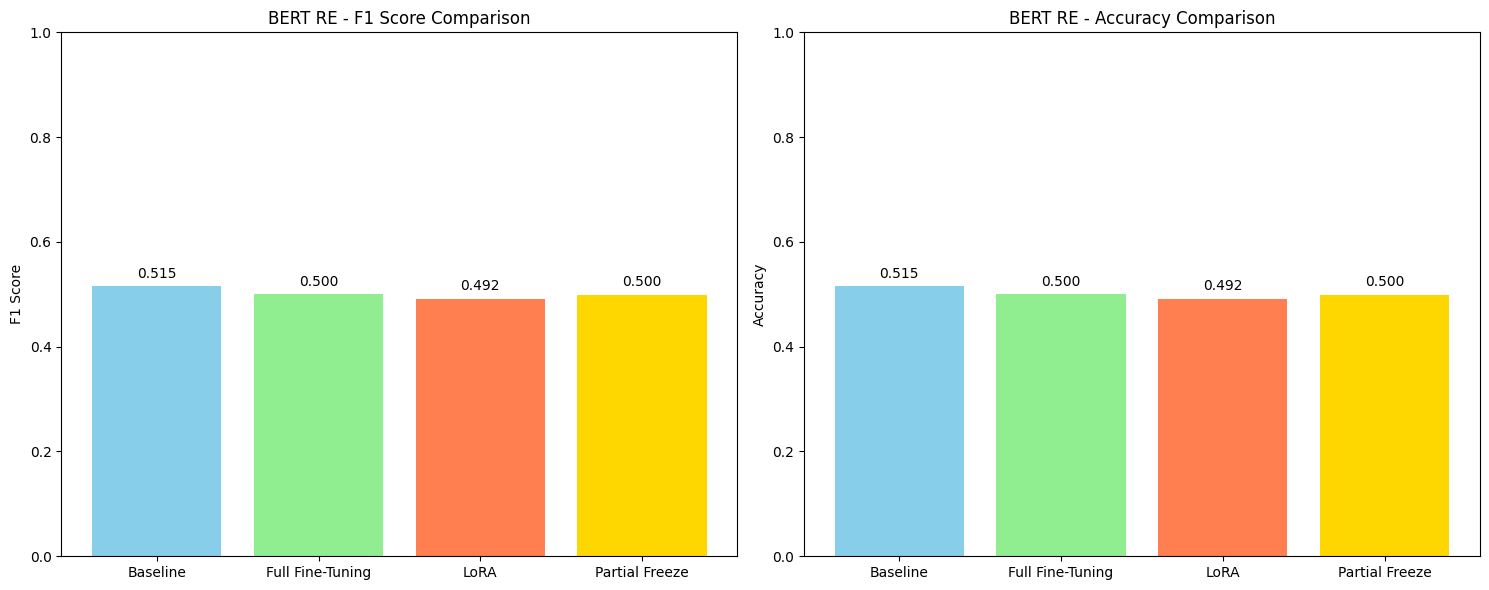


🏆 Best performing method: Baseline
   F1 Score: 0.5154
   Accuracy: 0.5154


In [15]:
# Compile results
results_summary = {
    "Method": ["Baseline", "Full Fine-Tuning", "LoRA", "Partial Freeze"],
    "Dev F1": [
        baseline_results["eval_f1"],
        final_ft_results["eval_f1"],
        final_lora_results["eval_f1"],
        final_freeze_results["eval_f1"]
    ],
    "Dev Accuracy": [
        baseline_results["eval_accuracy"],
        final_ft_results["eval_accuracy"],
        final_lora_results["eval_accuracy"],
        final_freeze_results["eval_accuracy"]
    ]
}

results_df = pd.DataFrame(results_summary)
print("\n" + "="*50)
print("BERT RELATION EXTRACTION - FINAL RESULTS")
print("="*50)
print(results_df.to_string(index=False, float_format='%.4f'))

# Visualize results
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

# F1 Score comparison
ax1.bar(results_df["Method"], results_df["Dev F1"], color=['skyblue', 'lightgreen', 'coral', 'gold'])
ax1.set_title("BERT RE - F1 Score Comparison")
ax1.set_ylabel("F1 Score")
ax1.set_ylim(0, 1)
for i, v in enumerate(results_df["Dev F1"]):
    ax1.text(i, v + 0.01, f'{v:.3f}', ha='center', va='bottom')

# Accuracy comparison
ax2.bar(results_df["Method"], results_df["Dev Accuracy"], color=['skyblue', 'lightgreen', 'coral', 'gold'])
ax2.set_title("BERT RE - Accuracy Comparison")
ax2.set_ylabel("Accuracy")
ax2.set_ylim(0, 1)
for i, v in enumerate(results_df["Dev Accuracy"]):
    ax2.text(i, v + 0.01, f'{v:.3f}', ha='center', va='bottom')

plt.tight_layout()
plt.show()

# Best performing method
best_method_idx = np.argmax(results_df["Dev F1"])
best_method = results_df.iloc[best_method_idx]
print(f"\n🏆 Best performing method: {best_method['Method']}")
print(f"   F1 Score: {best_method['Dev F1']:.4f}")
print(f"   Accuracy: {best_method['Dev Accuracy']:.4f}")

## 13. Hyperparameter Analysis


HYPERPARAMETER ANALYSIS

📊 Full Fine-Tuning Best Parameters:
  learning_rate: 1.9690687839546327e-05
  batch_size: 16

📊 LoRA Best Parameters:
  learning_rate: 0.00046474260073101195
  r: 16
  alpha: 32
  dropout: 0.26915667575813446
  batch_size: 32

📊 Partial Freeze Best Parameters:
  learning_rate: 4.9656563169526164e-05
  batch_size: 32
  freeze_pct: 0.5343784303061685


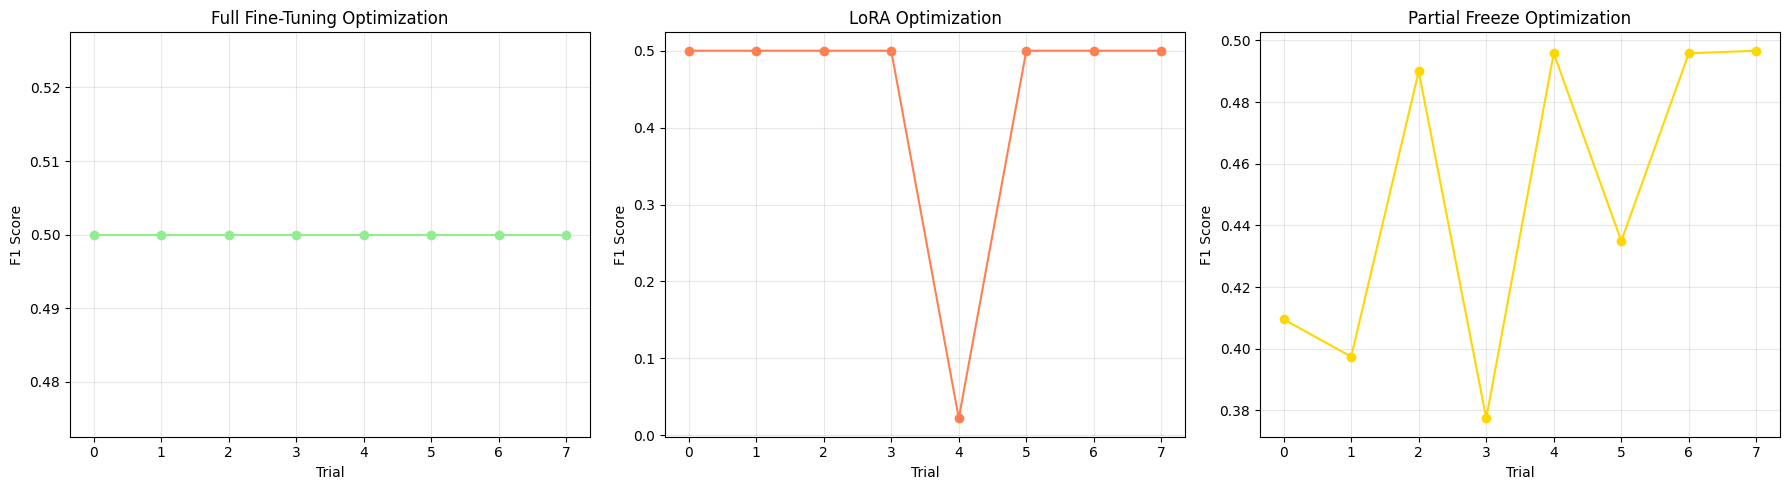

In [16]:
# Analyze hyperparameter importance
print("\n" + "="*50)
print("HYPERPARAMETER ANALYSIS")
print("="*50)

print("\n📊 Full Fine-Tuning Best Parameters:")
for param, value in best_ft_params.items():
    print(f"  {param}: {value}")

print(f"\n📊 LoRA Best Parameters:")
for param, value in best_lora_params.items():
    print(f"  {param}: {value}")

print(f"\n📊 Partial Freeze Best Parameters:")
for param, value in best_freeze_params.items():
    print(f"  {param}: {value}")

# Plot hyperparameter optimization history
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# Full FT optimization history
ft_values = [trial.value for trial in study_ft.trials if trial.value is not None]
axes[0].plot(ft_values, 'o-', color='lightgreen')
axes[0].set_title('Full Fine-Tuning Optimization')
axes[0].set_xlabel('Trial')
axes[0].set_ylabel('F1 Score')
axes[0].grid(True, alpha=0.3)

# LoRA optimization history
lora_values = [trial.value for trial in study_lora.trials if trial.value is not None]
axes[1].plot(lora_values, 'o-', color='coral')
axes[1].set_title('LoRA Optimization')
axes[1].set_xlabel('Trial')
axes[1].set_ylabel('F1 Score')
axes[1].grid(True, alpha=0.3)

# Freeze optimization history
freeze_values = [trial.value for trial in study_freeze.trials if trial.value is not None]
axes[2].plot(freeze_values, 'o-', color='gold')
axes[2].set_title('Partial Freeze Optimization')
axes[2].set_xlabel('Trial')
axes[2].set_ylabel('F1 Score')
axes[2].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

In [18]:
!zip -r /kaggle/working/working_dir1.zip /kaggle/working/outputs/*

  adding: kaggle/working/outputs/bert-ner-baseline/ (stored 0%)
  adding: kaggle/working/outputs/bert-ner-baseline/checkpoint-60/ (stored 0%)
  adding: kaggle/working/outputs/bert-ner-baseline/checkpoint-60/optimizer.pt

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


 (deflated 22%)
  adding: kaggle/working/outputs/bert-ner-baseline/checkpoint-60/training_args.bin (deflated 51%)
  adding: kaggle/working/outputs/bert-ner-baseline/checkpoint-60/scheduler.pt (deflated 56%)
  adding: kaggle/working/outputs/bert-ner-baseline/checkpoint-60/model.safetensors (deflated 7%)
  adding: kaggle/working/outputs/bert-ner-baseline/checkpoint-60/rng_state.pth (deflated 25%)
  adding: kaggle/working/outputs/bert-ner-baseline/checkpoint-60/scaler.pt (deflated 60%)
  adding: kaggle/working/outputs/bert-ner-baseline/checkpoint-60/trainer_state.json (deflated 67%)
  adding: kaggle/working/outputs/bert-ner-baseline/checkpoint-60/vocab.txt (deflated 53%)
  adding: kaggle/working/outputs/bert-ner-baseline/checkpoint-60/tokenizer_config.json (deflated 75%)
  adding: kaggle/working/outputs/bert-ner-baseline/checkpoint-60/config.json (deflated 64%)
  adding: kaggle/working/outputs/bert-ner-baseline/checkpoint-60/tokenizer.json (deflated 71%)
  adding: kaggle/working/outputs/b